# Weekly Larsson Strategy Analysis

**Goal**: Test weekly timeframe strategies based on:
- Weekly Larsson state (P1, P2, N1, N2)
- Closing price vs 200 Day SMA
- State transitions as entry/exit signals

**Strategy Variations**:
1. **Pure P1 Trend**: Enter P1, Exit N1/N2 (ride full trends)
2. **Strict P1 Only**: Enter P1, Exit P2 (take quick profits)
3. **Breakout Confirmation**: Enter P2→P1, Exit N1/N2 (wait for confirmation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports loaded")

✓ Imports loaded


## 1. Generate Weekly Reports

First, generate weekly scanner reports for NASDAQ 100.

In [ ]:
# Generate current week's report
!python ../src/generate_weekly_reports.py

## 2. Load and Explore Weekly Data

In [2]:
# Load the most recent weekly report
reports_dir = Path('../scanner_results/weekly_larsson')
reports = sorted(reports_dir.glob('nasdaq100_weekly_*.xlsx'))

if len(reports) > 0:
    latest_report = reports[-1]
    print(f"Loading: {latest_report.name}")
    
    df = pd.read_excel(latest_report, sheet_name='Weekly Data')
    print(f"\nLoaded {len(df)} tickers")
    print(f"\nColumns: {list(df.columns)}")
    display(df.head(10))
else:
    print("No reports found. Run generate_weekly_reports.py first.")

Loading: nasdaq100_weekly_20260115.xlsx

Loaded 9 tickers

Columns: ['Ticker', 'Week_End', 'Close', 'D200', 'Distance_D200_Pct', 'Weekly_Larsson', 'ROC_4W', 'Volume']


,Ticker,Week_End,Close,D200,Distance_D200_Pct,Weekly_Larsson,ROC_4W,Volume
0,ASML,2026-01-09,1273.88,856.10,48.80,P1,17.86,10614400
1,AMD,2026-01-09,203.17,165.76,22.57,P1,-3.61,153412100
2,TSLA,2026-01-09,445.01,364.75,22.00,P1,-3.04,341236000
3,ALAB,2026-01-09,162.61,136.86,18.81,P1,9.24,28684000
4,AVGO,2026-01-09,344.97,292.71,17.85,P1,-3.97,125388500
5,NVDA,2026-01-09,184.86,162.17,13.99,P1,5.62,817720000
6,MRVL,2026-01-09,83.22,74.68,11.44,P1,-1.36,87064100
7,BTC-USD,2026-01-09,90513.10,106421.58,-14.95,N2,0.27,277506231236
8,SOL-USD,2026-01-09,135.76,172.85,-21.46,N2,2.59,30224153048


## 3. Weekly State Distribution

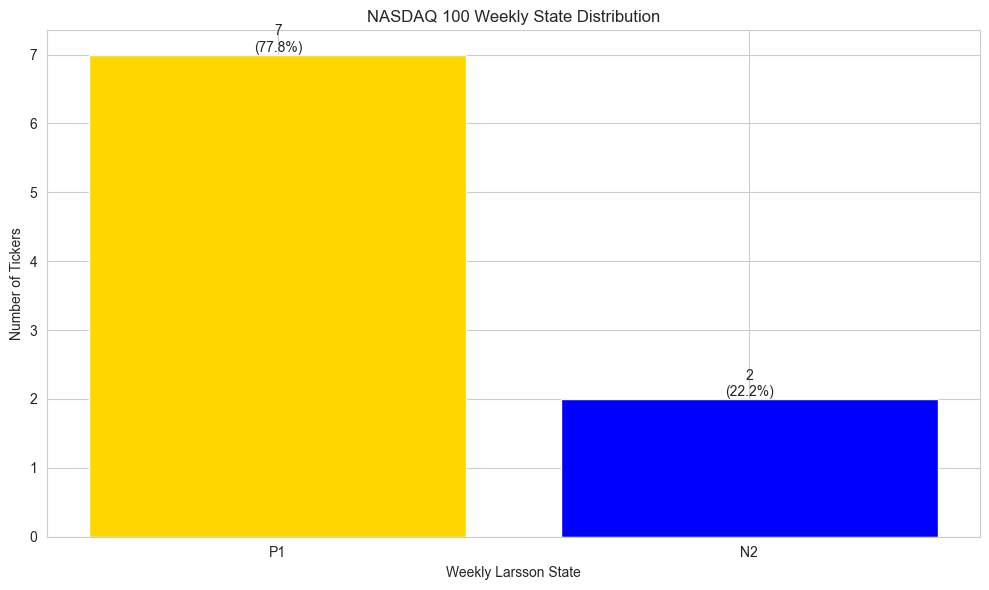


State Summary:
  P1: 7 tickers (77.8%)
  N2: 2 tickers (22.2%)


In [3]:
# Count tickers in each state
state_counts = df['Weekly_Larsson'].value_counts()

# Plot distribution
fig, ax = plt.subplots(figsize=(10, 6))
colors = {'P1': 'gold', 'P2': 'gray', 'N1': 'lightgray', 'N2': 'blue'}
bars = ax.bar(state_counts.index, state_counts.values, 
              color=[colors.get(s, 'gray') for s in state_counts.index])

# Add percentages
for i, (state, count) in enumerate(state_counts.items()):
    pct = count / len(df) * 100
    ax.text(i, count, f'{count}\n({pct:.1f}%)', ha='center', va='bottom')

ax.set_xlabel('Weekly Larsson State')
ax.set_ylabel('Number of Tickers')
ax.set_title('NASDAQ 100 Weekly State Distribution')
plt.tight_layout()
plt.show()

print("\nState Summary:")
for state, count in state_counts.items():
    pct = count / len(df) * 100
    print(f"  {state}: {count} tickers ({pct:.1f}%)")

## 4. Distance from D200 by State

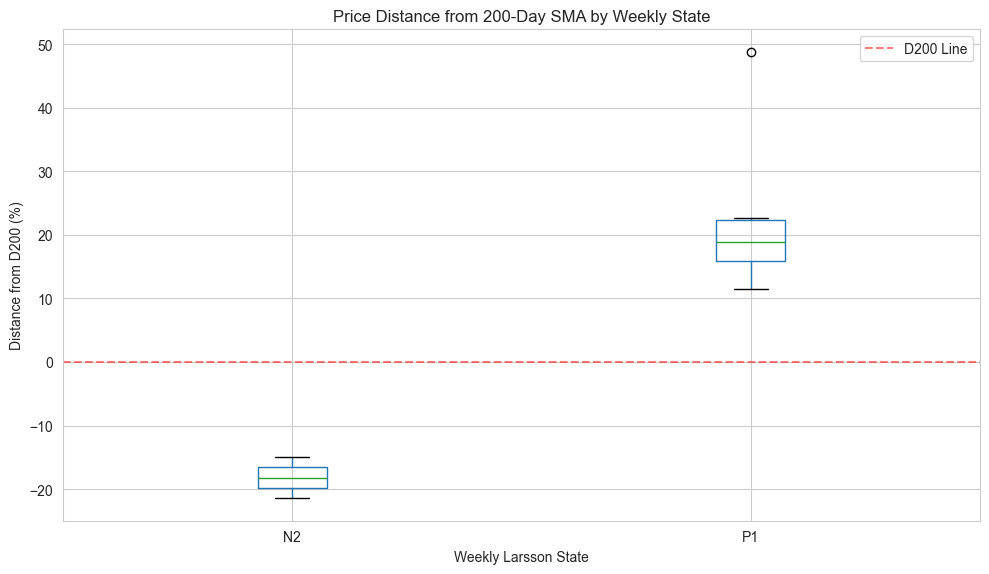


Distance from D200 Statistics:
                count       mean        std    min      25%     50%      75%  \
Weekly_Larsson                                                                 
N2                2.0 -18.205000   4.603265 -21.46 -19.8325 -18.205 -16.5775   
P1                7.0  22.208571  12.391749  11.44  15.9200  18.810  22.2850   

                  max  
Weekly_Larsson         
N2             -14.95  
P1              48.80  


In [4]:
# Box plot of distance from D200 by state
fig, ax = plt.subplots(figsize=(10, 6))
df.boxplot(column='Distance_D200_Pct', by='Weekly_Larsson', ax=ax)
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='D200 Line')
ax.set_xlabel('Weekly Larsson State')
ax.set_ylabel('Distance from D200 (%)')
ax.set_title('Price Distance from 200-Day SMA by Weekly State')
ax.legend()
plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

# Statistics by state
print("\nDistance from D200 Statistics:")
print(df.groupby('Weekly_Larsson')['Distance_D200_Pct'].describe())

## 5. Top P1 Candidates (Entry Signals)

In [5]:
# Filter for P1 state (strong bullish)
p1_tickers = df[df['Weekly_Larsson'] == 'P1'].sort_values('ROC_4W', ascending=False)

print(f"P1 (Strong Bullish) Tickers: {len(p1_tickers)}")
print("\nTop 10 by momentum (4-week ROC):")
display(p1_tickers[['Ticker', 'Close', 'D200', 'Distance_D200_Pct', 'ROC_4W']].head(10))

P1 (Strong Bullish) Tickers: 7

Top 10 by momentum (4-week ROC):


,Ticker,Close,D200,Distance_D200_Pct,ROC_4W
0,ASML,1273.88,856.10,48.80,17.86
3,ALAB,162.61,136.86,18.81,9.24
5,NVDA,184.86,162.17,13.99,5.62
6,MRVL,83.22,74.68,11.44,-1.36
2,TSLA,445.01,364.75,22.00,-3.04
1,AMD,203.17,165.76,22.57,-3.61
4,AVGO,344.97,292.71,17.85,-3.97


## 6. P2→P1 Transition Candidates (Breakout Strategy)

In [ ]:
# P2 tickers close to breaking into P1
# (Above D200, positive momentum, close to 5% ROC threshold)
p2_tickers = df[df['Weekly_Larsson'] == 'P2'].copy()
p2_tickers['Score'] = p2_tickers['ROC_4W'] + p2_tickers['Distance_D200_Pct']
p2_tickers = p2_tickers.sort_values('Score', ascending=False)

print(f"P2 (Consolidation) Tickers: {len(p2_tickers)}")
print("\nTop 10 closest to P1 breakout:")
display(p2_tickers[['Ticker', 'Close', 'D200', 'Distance_D200_Pct', 'ROC_4W', 'Score']].head(10))

## 7. Generate Historical Reports for Backtesting

Generate weekly reports from 2021 to present for strategy backtesting.

In [6]:
# Generate 5 years of historical weekly reports
# This will take some time (downloading data for 50-100 tickers x 260 weeks)

start_date = "2021-01-01"
end_date = "2025-12-31"

print(f"Generating weekly reports from {start_date} to {end_date}...")
print("This will take 10-15 minutes...\n")

!python ../src/generate_weekly_reports.py {start_date} {end_date}

Generating weekly reports from 2021-01-01 to 2025-12-31...
This will take 10-15 minutes...

Using default NASDAQ 100 tickers

GENERATING WEEKLY REPORTS: 2021-01-01 to 2025-12-31


Week ending: 2021-01-01
Scanning for week ending: 2021-01-01
  [1/50] Processing AAPL...
  [2/50] Processing MSFT...
  [3/50] Processing AMZN...
  [4/50] Processing NVDA...
  [5/50] Processing GOOGL...
  [6/50] Processing META...
  [7/50] Processing GOOG...
  [8/50] Processing TSLA...
  [9/50] Processing AVGO...
  [10/50] Processing COST...
  [11/50] Processing NFLX...
  [12/50] Processing ASML...
  [13/50] Processing AMD...
  [14/50] Processing PEP...
  [15/50] Processing ADBE...
  [16/50] Processing CSCO...
  [17/50] Processing TMUS...
  [18/50] Processing LIN...
  [19/50] Processing CMCSA...
  [20/50] Processing TXN...
  [21/50] Processing QCOM...
  [22/50] Processing INTU...
  [23/50] Processing AMAT...
  [24/50] Processing HON...
  [25/50] Processing AMGN...
  [26/50] Processing ISRG...
  [27/50] Process

## 8. Verify Generated Reports

In [7]:
# Check how many reports were generated
reports = sorted(reports_dir.glob('nasdaq100_weekly_*.xlsx'))
print(f"Total weekly reports: {len(reports)}")

if len(reports) > 0:
    print(f"\nFirst report: {reports[0].name}")
    print(f"Last report: {reports[-1].name}")
    
    # Check coverage
    dates = [r.stem.split('_')[-1] for r in reports]
    print(f"\nDate range: {dates[0]} to {dates[-1]}")
    print(f"Expected weeks: ~{52*5} (5 years)")
    print(f"Actual weeks: {len(reports)}")

Total weekly reports: 1

First report: nasdaq100_weekly_20260115.xlsx
Last report: nasdaq100_weekly_20260115.xlsx

Date range: 20260115 to 20260115
Expected weeks: ~260 (5 years)
Actual weeks: 1


## 9. Next Steps

Once historical reports are generated:

1. **Update backtest script** to read from `scanner_results/weekly_larsson/`
2. **Run backtest** with 3 strategy variations
3. **Compare results**: Win rate, avg return, hold time
4. **Optimize**: Adjust entry/exit thresholds based on results